# Generating new place names in County Durham with a transformer

In this notebook we generate new place names in County Durham using the transformer architecture that was introduced in the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) by Vaswami et al. The transformer has facilitated many breakthroughs in deep learning. Here we implement a decoder model based on a transformer that outperforms all of our previous models from bigrams to WaveNet.

Our code is largely based on the [Andrej Karpathy lecture](https://www.youtube.com/watch?v=kCc8FmEb1nY&t=4920s).

<font color='0789DF'>Table of contents<font><a class='anchor' id='top'></a>
- [Setting up](#settingup)
- [The transformer architecture](#transarch)
- [Self-attention](#selfatt)
- [Multi-head attention](#mhatt)
- [Building the decoder](#build)
- [Training the decoder](#train)
- [Evaluating the decoder](#eval)
- [Generating new place names with the decoder](#gen)

## Setting up <a class="anchor" id="settingup">

We load in the requisite libraries and prepare our data from the corpus of place names `place_names_durham.txt`. We refer the reader to earlier notebooks for more details about the set up here.

In [1]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

# load in the corpus of place names
place_names_durham = open('place_names_durham.txt', 'r').read().splitlines()

# characters in place_names_durham corpus
chars = sorted(list(set(''.join(place_names_durham))))

# character to index dictionary
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0   # end token

# index to character dictionary
itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

In [2]:
import random
random.seed(42)
random.shuffle(place_names_durham)

block_size = 8

def build_dataset(corpus):  
    X, Y = [], []
    for w in corpus:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context[:block_size])  
            Y.append(context[1:] + [ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n1 = int(0.8*len(place_names_durham))
n2 = int(0.9*len(place_names_durham))
Xtr,  Ytr  = build_dataset(place_names_durham[:n1])     
Xdev, Ydev = build_dataset(place_names_durham[n1:n2])   
Xte,  Yte  = build_dataset(place_names_durham[n2:])     

print(f"Shape of Xtr: {Xtr.shape}")
print(f"Shape of Ytr: {Ytr.shape}")
print(f"Shape of Xdev: {Xdev.shape}")
print(f"Shape of Ydev: {Ydev.shape}")
print(f"Shape of Xte: {Xte.shape}")
print(f"Shape of Yte: {Yte.shape}")

Shape of Xtr: torch.Size([11433, 8])
Shape of Ytr: torch.Size([11433, 8])
Shape of Xdev: torch.Size([1429, 8])
Shape of Ydev: torch.Size([1429, 8])
Shape of Xte: torch.Size([1428, 8])
Shape of Yte: torch.Size([1428, 8])


## The transformer architecture <a class="anchor" id="transarch">

The transformer architecture emerged as a way to improve upon recurrent neural networks to produce state-of-the-art results in language modeling and machine translation. The basis of transformers is the *attention* mechanism. We refer the reader to the excellent article [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/) by Jay Alammar for more details about attention in order to be concise in this notebook.

The following image is from the original transformer paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) and outlines an encoder-decoder model that could be trained for translation or question-answering tasks.

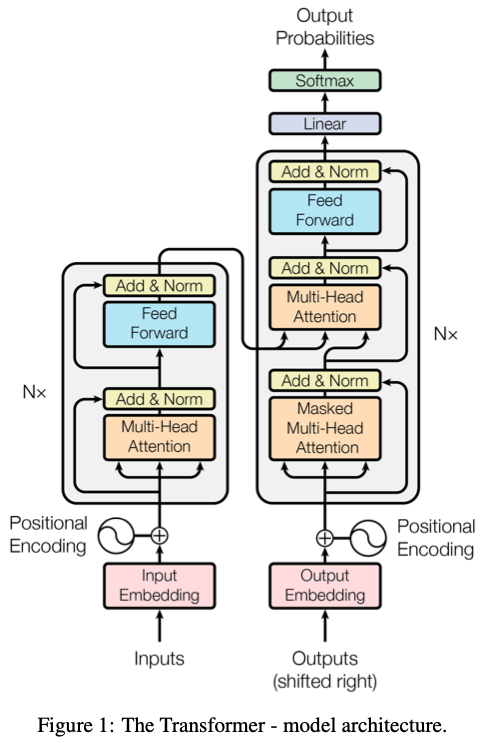

For generating new place names, we only need the decoder model. The idea is that our place names are encoded as tokens that are then embedded in a higher dimensional space. These embeddings are fed through the network that consists of blocks where attention is implemented. The output are the softmax probabilities of each character being the next in the sequence. 

Our goal now is to build the blocks corresponding to the masked multihead attention in Figure 1 that is from the paper *Attention Is All You Need*.

## Self-attention <a class="anchor" id="selfatt">

Below we create the class `Head` that implements self-attention. Given an input `x`, the attention head will compute the attention function given a set of keys, queries and values that the model will optimise.

In [3]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input size: (batch, time-step, channels)
        # output size: (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        # compute attention scores
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        # weighted aggregation of the values
        v = self.value(x) 
        out = wei @ v
        return out

## Multi-head attention <a class="anchor" id="mhatt">

Instead of averaging over single attention heads, we linearly project different learned queries, keys and values and calculate attention functions in parallel that are then concatenated and projected again. We refer to [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer) for precise details.

In [4]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

## Building the decoder <a class="anchor" id="build">

With a multihead attention mechanism in place, we are ready to build our decoder.

First, we construct the blocks that consist of a multihead attention head and a feed-forward neural network, with layer normalisation at intermediate steps. Below we build the feed-forward neural network.

In [5]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

With all the elements required for our block, we construct it below.

In [6]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

We have all the parts needed to build our decoder. The steps through the network are as follows:
 - Tokens are embedded in `n_embd`-dimensional space where `n_embd` is a hyperparameter.
 - To the embedded tokens we add a positional embedding to represent character location.
 - The embedded tokens are passed through `n_layer` blocks constructed above where `n_layer` is a hyperparameter.
 - A final layer normalisation is added after the blocks.
 - A final linear layer outputs the logit values.

In [7]:
class Decoder(nn.Module):

    def __init__(self):
        super().__init__()
        # each token reads off the logits for the next token through a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets have size (B,T)
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb 
        x = self.blocks(x) 
        x = self.ln_f(x)
        logits = self.lm_head(x)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits_flat = logits.view(B*T, C)
            targets_flat = targets.view(B*T)
            loss = F.cross_entropy(logits_flat, targets_flat)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # generate predictions
            logits, loss = self(idx_cond)
            # look at last time step
            logits = logits[:, -1, :] 
            # softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # sample 
            idx_next = torch.multinomial(probs, num_samples=1) 
            # append sampled index to sequence
            idx = torch.cat((idx, idx_next), dim=1)
            if idx_next == 0:
                break
        return idx

## Training the decoder <a class="anchor" id="train">

We are ready to train our decoder model.

First we set the hyperparameters, instantiate the model and define the optimiser.

In [8]:
# hyperparameters
batch_size = 32
eval_interval = 1000
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 70
n_head = 6
n_layer = 6
dropout = 0.5

# set random seed
torch.manual_seed(1337)

# instantiate the decoder and set to device
model = Decoder()
m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

0.35521 M parameters


We train the decoder model with the standard training loop.

In [9]:
# number of training steps
max_steps = 25000

# lists to store training and validation loss through training
lossi = []
lossvali = []

for i in range(max_steps):
  
    # build minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    # forward pass
    logits, loss = m(Xb, Yb)
    # backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    # optimise
    optimizer.step()

    # track stats and validation loss
    if i % 1000 == 0:
        with torch.no_grad():
            logits_valid, loss_valid = m(Xdev, Ydev)
            lossvali.append(loss_valid.log10().item())
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    else:
        lossvali.append(loss_valid.log10().item())
    lossi.append(loss.log10().item())

      0/  25000: 3.4139
   1000/  25000: 1.7455
   2000/  25000: 1.8720
   3000/  25000: 1.5898
   4000/  25000: 1.5628
   5000/  25000: 1.4462
   6000/  25000: 1.5702
   7000/  25000: 1.3109
   8000/  25000: 1.5433
   9000/  25000: 1.3053
  10000/  25000: 1.3880
  11000/  25000: 1.3051
  12000/  25000: 1.4125
  13000/  25000: 1.3277
  14000/  25000: 1.3279
  15000/  25000: 1.1775
  16000/  25000: 1.3315
  17000/  25000: 1.3446
  18000/  25000: 1.3329
  19000/  25000: 1.1837
  20000/  25000: 1.3034
  21000/  25000: 1.2708
  22000/  25000: 1.2411
  23000/  25000: 1.1914
  24000/  25000: 1.0506


Let's visualise how successful training went by comparing the training loss and validation loss over the training loop.

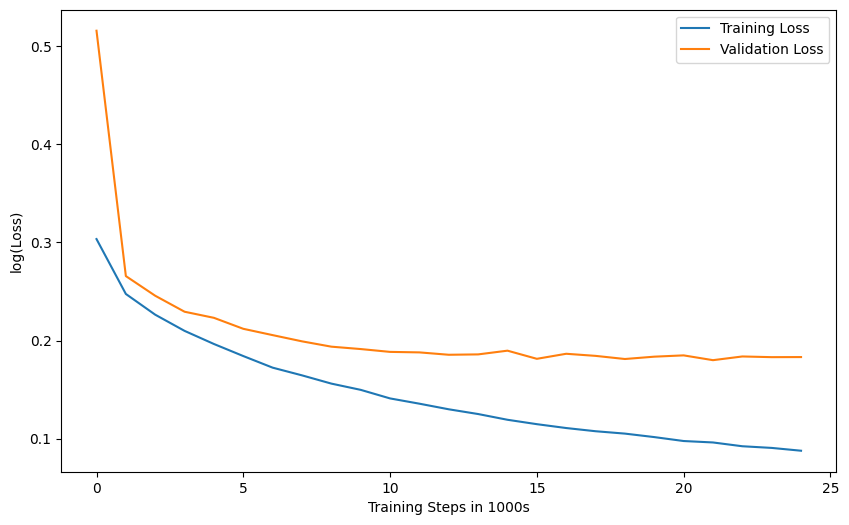

In [10]:
steps = list(range(0, int(max_steps/1000)))
loss_val = lossvali[0::1000]

plt.figure(figsize=(10, 6))
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1), label="Training Loss")
plt.plot(steps, loss_val, label="Validation Loss")
plt.xlabel("Training Steps in 1000s")
plt.ylabel("log(Loss)")
plt.legend()
plt.show()

## Evaluating the decoder <a class="anchor" id="eval">

To determine how well our model is performing, let's evaluate the loss on the training set, validation set and the test set.

In [11]:
@torch.no_grad()
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    logits, loss = m(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 1.2282687425613403
val 1.5289944410324097
test 1.5471470355987549


An improvement from our WaveNet model, which is impressive considering our transformer model had fewer parameters and was trained in less time!

## Generating new place names with the decoder <a class="anchor" id="gen">

To see how well our decoder model performs, let's see what place names it generates!

In [12]:
decode = lambda l: ''.join([itos[i] for i in l])

for _ in range(20):
    context = torch.ones((1, 1), dtype=torch.long, device=device)
    gen_name = decode(m.generate(idx=context, max_new_tokens=30)[0].tolist()).title()
    print(gen_name)

 Burn Op.
 Ashine Ndral.
 And Station.
 Som Springton.
 Tynew Gate.
 Sunny Panates.
 Askerle.
 Job'S Clea.
 Olmsilk.
 Gatherme.
 Anchburn.
 Skalton.
 Greatingt.
 Parkham.
 Shopweat.
 Herburn.
 Thernes.
 Swairton.
 Humley Hill.
 Swainsworth.
